In this notebook, we compute the weight maps or phenotypes by fitting the entire set of observations for scores in which stacking led to improvement in the prediction accuracies. 

**R1: We take into account the interpretation of weights by multiplying these by the covariance sample matrix of in channels or brain measurement**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from os.path import join as opj
import os
import sys
import matplotlib.pylab as plt
import h5py

#Sklearn stuff
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import  StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

from sklearn.metrics import mean_absolute_error, r2_score

from scipy.stats import ks_2samp

In [2]:
sys.path.append("/home/javi/Documentos/multimodal-cognition/")
from stacking import StackingLassoCV

In [3]:
sns.set(font="Arial")

In [4]:
RANDOM_STATE = 0

Load the data

In [5]:
f =  h5py.File(opj("../data", "final_data_R1.hdf5"), "r")

# Response  data
YY_domain_cognition =  f['YY_domain_cognition'][:]
# Independent data
X_conn = f['connectome_features'][:]
X_surf = f['surface_features'][:]
X_thic = f['thickness_features'][:]
X_subv = f['sub_vols_features'][:]
X_locc = f['loc_conn_features'][:]

# Confounders
X_conf = f['confounder_features'][:]
icv_var = f['intracv_feature'][:]

# Subjects ID
subjects = f['subjects'][:]
f.close()

In [6]:
list_X_sources = [X_conn, 
                  X_surf,
                  X_thic,
                  X_subv,
                  X_locc]

In [10]:
# As we said, take cognitive scores where stacking improved
score_names = ['CogTotalComp_Unadj', 'CogFluidComp_Unadj', 'CogCrystalComp_Unadj', 
                'DDisc_AUC_200', 'VSPLOT_TC']

modality_names = ['CONNECTOME', 'SURFACE', 'THICKNESS', 'SUB_VOLUMES', 'LOCAL_CONN']
n_scores = len(score_names) 
n_mods = len(modality_names)
n_obs = YY_domain_cognition.shape[0]

In [9]:
def regress_out(YY_train, YY_test, M_train, M_test):
    
    """
    
    Function used to adjust data using a simple linear regression
    
    """
    
    linReg = LinearRegression() 
    # Fit using ONLY training data
    linReg.fit(M_train, YY_train)
    
    # Substract predicted values and add intercept to keep the same scale. 
    YY_train_adj = YY_train - linReg.predict(M_train) + linReg.intercept_
    YY_test_adj = YY_test - linReg.predict(M_test) + linReg.intercept_
    
    return YY_train_adj, YY_test_adj

In [10]:
from sklearn.linear_model import LinearRegression
linReg = LinearRegression() 
linReg.fit(icv_var[:, np.newaxis], YY_domain_cognition)
    
YY_adj_icv = YY_domain_cognition - linReg.predict(icv_var[:, np.newaxis]) + linReg.intercept_

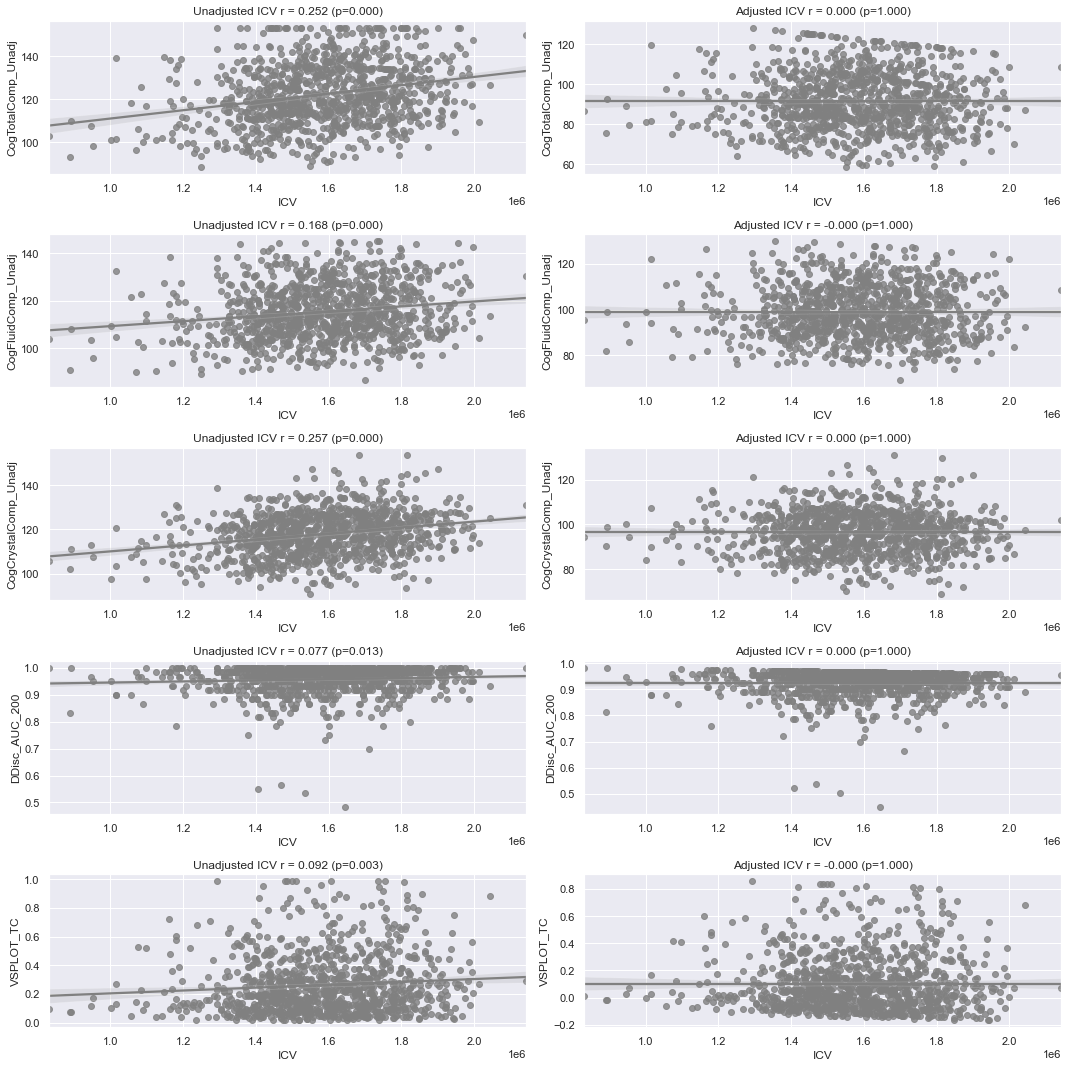

In [10]:
from scipy.stats import pearsonr
fig, axs = plt.subplots(ncols=2, nrows=n_scores, figsize=(15, 15))

for ii, name in enumerate(score_names):
    r, p = pearsonr(icv_var, YY_domain_cognition[:, ii])
    sns.regplot(x = "ICV", y = name, data = pd.DataFrame({"ICV": icv_var, name: YY_domain_cognition[:, ii]}),
                ax=axs[ii,0], color='grey')
    axs[ii, 0].set_title("Unadjusted ICV r = %.3f (p=%.3f)" % (r , p))
    
    r, p = pearsonr(icv_var, YY_adj_icv[:, ii])
    sns.regplot(x = "ICV", y = name, data = pd.DataFrame({"ICV": icv_var, name: YY_adj_icv[:, ii]}), 
                 ax=axs[ii,1], color='grey')
    axs[ii, 1].set_title("Adjusted ICV r = %.3f (p=%.3f)" % (r, p))
    
plt.tight_layout()

In [11]:
import glob
#vol_measures = pd.read_csv(glob.glob(opj(data_dir, "final", "structural","*", "sub_volumes.txt"))[0], sep='\t').iloc[:,0].values

vt = VarianceThreshold()
#vt.fit(list_X_sources[3])
#pd.DataFrame({'measure': vol_measures, 'included': vt.get_support()}).to_csv('../data/vol_features_support.csv', 
 #                                                                            sep='\t', index=False)

In [12]:
print([X.shape[1] for X in [X_conn, X_surf, X_thic, X_subv, X_locc]])
print([VarianceThreshold().fit_transform(X).shape[1] for X in [X_conn, X_surf, X_thic, X_subv, X_locc]])

[257403, 360, 360, 65, 128894]
[257403, 360, 360, 61, 128894]


Compute covariance matrices, which will multiple the phenotypes so that we can now intrepret them correctly, as though they would correspond to an encoding model

First, we need to keep in mind that we are  performing a standarization the PCA, so in the end it's like we are doing a LASSO-PCR on these scaled features and therefore, we should use the the covariance matrix on based on the standarized features

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
ss = StandardScaler()

In [11]:
list_X_ss = [ss.fit_transform(X) for X in [X_conn, X_surf, X_thic, X_subv, X_locc]]

# We need to keep in mind that there are 4 features in the volumentric channel that are always discarded
# because they have the same value across all observations. This only happens to channel ( see at the end this notebook)
list_X_ss[3] = ss.fit_transform(VarianceThreshold().fit_transform(X_subv))

ddofs = n_obs-1 # This is the factor dividing the cross-products in the covariance matrix (i.e. to compute the expected value)

Instead of computing directly the covariance matrix and then multiplying it by the weight map, which for the local connectome and resting-state connectivity would give a matrix that does not fit in memory, we are going to use the definition of the covarince matrix as the multiplication of the transpose input data and the input data divided by the degrees of freedom (since we are using standarized features, we don't need to substract the mean to each column).

$ w = V * \vec{beta} $ the weight map in the original feature axes and not the PCA axes.

$ Cov * w = Cov * V * \vec{beta} = \frac{1}{ddof}(X^T * X) * V * \vec{beta} $

In [27]:
# We can see this gives the same as for instane using the function cov of numpy
surf_cov_numpy = np.cov(list_X_ss[1].T) # Covariance using numpy
surf_cov_def = 1/ddofs*(list_X_ss[1].T @ list_X_ss[1]) # Convariance using the definition of covariance

print("the similary between both matrices is: ", np.corrcoef(surf_cov_numpy.flatten(), surf_cov_def.flatten())[0,1])

the similary between both matrices is:  0.9999999999999999


In [34]:
with h5py.File(opj("../results", "weights_phenotypes_R1.hdf5"), "w") as f:

    #save the phenotypes for each case
    for ii, score in zip([0,1,2,4,6], score_names):

        print("computing phenotypes for score {}".format(score))

        #create a group for this score
        f.create_group(score)

        prepend_transformation = [VarianceThreshold(), StandardScaler(), PCA()]
        stack_lasso = StackingLassoCV(prepend_transformation=prepend_transformation, cv=5,
                                      n_jobs=1, random_state = RANDOM_STATE)

        y = YY_adj_icv[:, ii]

        print("first level fitting")
        
        #Fit stack lasso model
        stack_lasso.fit(list_X_sources, y)

        # Use fitted models to compute the phenotype and save to disk
        for jj, mod in enumerate(modality_names):
            
            # pca.components == V^T in the paper, with dims comps x features
            # beta is comps
            # then, we have to multiply beta x pca.components here
            # In the paper w = V x beta, but this is for column vectors
            # for a row vector w^T = V x beta^T, where V has dims features x comps
            
            X_ss = list_X_ss[jj] # The input feature matrices before the PCA
            
            V = stack_lasso.transformers_[jj].named_steps['pca'].components_.T
            betas = stack_lasso.estimators_[jj].coef_[:, np.newaxis]
            
            prediction_pattern = np.matmul(V, betas)
            f[score].create_dataset("prediction_pattern_" + mod, data = np.squeeze(prediction_pattern))
            
            # Cov x w = Cov x V x beta 
            #         = 1/ddof*(X.T x X) x V x beta
            # This is done in this way for computational reasons, given that computing the 
            # covariance matrix of a big feature matrix (e.g. local connectome and resting) 
            # may make the computer run out of mem
            
            activation_pattern = 1/ddofs*X_ss.T @ (X_ss @ prediction_pattern)
            
            #Create a dataset for each modality in this group score
            f[score].create_dataset("activation_pattern_" + mod, data=np.squeeze(activation_pattern))

        print("second level fitting")
        clf_2 = LassoCV(cv=5, random_state=RANDOM_STATE, positive=True)

        #Fit on the stacked predictions
        clf_2.fit(stack_lasso.stacked_features_, y)

        # Save also the channel weights provided by lassso on the stacked predictions
        f[score].create_dataset('channel_weights', data = clf_2.coef_)

        print("finished\n")

computing phenotypes for score CogTotalComp_Unadj
first level fitting
second level fitting
finished

computing phenotypes for score CogFluidComp_Unadj
first level fitting
second level fitting
finished

computing phenotypes for score CogCrystalComp_Unadj
first level fitting
second level fitting
finished

computing phenotypes for score DDisc_AUC_200
first level fitting
second level fitting
finished

computing phenotypes for score VSPLOT_TC
first level fitting
second level fitting
finished



Our estimtator, before the PCA, it also performs a Variance threshold feauture selection, aiming at discarding those features whose variance is null across all the observations. This only happens to volume features. And this is something that we have to keep in mind when plotting the weight maps.

In [28]:
vt = VarianceThreshold()

for (mod, XX) in zip(modality_names, list_X_sources):
    vt.fit(XX)
    print("%s, number of original features = %d,"
          " number of features after Variance Threshold = %d" % (mod, XX.shape[1], sum(vt.get_support())))

CONNECTOME, number of original features = 257403, number of features after Variance Threshold = 257403
SURFACE, number of original features = 360, number of features after Variance Threshold = 360
THICKNESS, number of original features = 360, number of features after Variance Threshold = 360
SUB_VOLUMES, number of original features = 65, number of features after Variance Threshold = 61
LOCAL_CONN, number of original features = 128894, number of features after Variance Threshold = 128894


In [30]:
vol_measures = ['Left-Lateral-Ventricle', 'Left-Inf-Lat-Vent', 'Left-Cerebellum-White-Matter',
                'Left-Cerebellum-Cortex','Left-Thalamus-Proper', 'Left-Caudate',
                'Left-Putamen', 'Left-Pallidum', '3rd-Ventricle',
                '4th-Ventricle','Brain-Stem','Left-Hippocampus',
                'Left-Amygdala', 'CSF', 'Left-Accumbens-area', 
                'Left-VentralDC', 'Left-vessel', 'Left-choroid-plexus',
                'Right-Lateral-Ventricle', 'Right-Inf-Lat-Vent', 'Right-Cerebellum-White-Matter',
                'Right-Cerebellum-Cortex', 'Right-Thalamus-Proper', 'Right-Caudate',
                'Right-Putamen', 'Right-Pallidum', 'Right-Hippocampus',
                'Right-Amygdala', 'Right-Accumbens-area', 'Right-VentralDC',
                'Right-vessel', 'Right-choroid-plexus', '5th-Ventricle',
                'WM-hypointensities', 'Left-WM-hypointensities', 'Right-WM-hypointensities',
                'non-WM-hypointensities', 'Left-non-WM-hypointensities', 'Right-non-WM-hypointensities',
                'Optic-Chiasm', 'CC_Posterior', 'CC_Mid_Posterior', 'CC_Central',
                'CC_Mid_Anterior', 'CC_Anterior', 'BrainSegVol',
                'BrainSegVolNotVent', 'BrainSegVolNotVentSurf','lhCortexVol',
                'rhCortexVol','CortexVol', 'lhCorticalWhiteMatterVol',
                'rhCorticalWhiteMatterVol', 'CorticalWhiteMatterVol', 'SubCortGrayVol',
                'TotalGrayVol', 'SupraTentorialVol', 'SupraTentorialVolNotVent',
                'SupraTentorialVolNotVentVox', 'MaskVol', 'BrainSegVol-to-eTIV',
                'MaskVol-to-eTIV', 'lhSurfaceHoles', 'rhSurfaceHoles',
                'SurfaceHoles']

In [31]:
# Save which features are kept
vt = VarianceThreshold()
vt.fit(list_X_sources[3])
pd.DataFrame({'measure': vol_measures, 
              'included': vt.get_support()}).to_csv('../results/vol_features_support.csv', sep='\t', index=False)

In [32]:
# These are the omitted features
list(np.array(vol_measures)[~vt.get_support()])

['Left-WM-hypointensities',
 'Right-WM-hypointensities',
 'Left-non-WM-hypointensities',
 'Right-non-WM-hypointensities']